In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [3]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [4]:
def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader

In [5]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [29]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3, stride=2)
#         self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
#         self.lin_mean = nn.Linear(64*6*6, latent_size)
#         self.lin_std = nn.Linear(64*6*6, latent_size)
        self.linear1 = nn.Linear(28*28, 256)
        self.linear2 = nn.Linear(256, 128)
        self.lin_mean = nn.Linear(128, latent_size)
        self.lin_std = nn.Linear(128, latent_size)
    
    def forward(self, x):
        imput_batch_size = x.shape[0]
#         print(x.shape)
#         x = torch.relu(self.conv1(x))
#         print(x.shape)
#         x = torch.relu(self.conv2(x))
#         print(x.shape)
        x = torch.reshape(x, (imput_batch_size, -1))
#         print(x.shape)
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.linear2(x))
        mean = self.lin_mean(x)
        std = self.lin_std(x)
#         print(x.shape)
        return mean, std
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
#         self.lin = nn.Linear(latent_size, 64*6*6)
#         self.deconv1 = nn.ConvTranspose2d(64, 32, 3, stride=2)
#         self.deconv2 = nn.ConvTranspose2d(32, 1, 3, stride=2, output_padding=1)
        self.linear1 = nn.Linear(latent_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 28*28)
    
    def forward(self, x):
        imput_batch_size = x.shape[0]
#         print(x.shape)
#         x = torch.tanh(self.lin(x))
#         print(x.shape)
#         x = torch.reshape(x, (50, 64, 6, 6))
#         print(x.shape)
#         x = torch.relu(self.deconv1(x))
#         print(x.shape)
#         x = torch.tanh(self.deconv2(x))
#         print(x.shape)
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        x = torch.reshape(x, (imput_batch_size, 1, 28, 28))
        return x

In [30]:
class Net(nn.Module):
    def __init__(self, latent_size=16, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self.z_mean = None
        self.z_log_sigma_sq = None
        self._loss = None
        self._latent_loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        self.z_mean, self.z_log_sigma_sq = self.E(x)
        
        epsilon = torch.randn_like(self.z_mean)
        z = self.z_mean + torch.sqrt(torch.exp(self.z_log_sigma_sq)) * epsilon
        
        out = self.D(z)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def latent_loss(self):
        self._latent_loss = -0.5 * torch.sum(1 + 
                                             self.z_log_sigma_sq - 
                                             self.z_mean ** 2 - 
                                             torch.exp(self.z_log_sigma_sq))
        return self._latent_loss
    
    def loss(self, x, target, **kwargs):
#         target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [31]:
models = {'net': Net(2)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [32]:
def train(epoch, models, log=None, noisy=False, zero_half=False):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        
        train_data = torch.Tensor(np.copy(data))
        if noisy:
            train_data += torch.randn_like(data)           
        if zero_half:
            train_data[:, :, :, :14] = 0                
        
        for model in models.values():
            model.optim.zero_grad()
            output = model(train_data)
            latent_loss = model.latent_loss()
            loss = model.loss(output, data) + latent_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            l_str = '{}: reconstruction - {:.6f}, latent - {:.6f}'
            losses = ' '.join([l_str.format(k, m._loss.item(), m._latent_loss) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        l_str = '{}: reconstruction - {:.6f}, latent - {:.6f}'
        losses = ' '.join([l_str.format(k, m._loss.item(), m._latent_loss) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._latent_loss))
        print(line + losses)

In [33]:
avg_lambda = lambda l: 'loss: {:.6f}'.format(l)
latent_lambda = lambda p: 'latent_loss: {:.6f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + latent_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    latent_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                latent_loss[k] += m.latent_loss()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        latent_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], latent_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], latent_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [34]:
for epoch in range(1, 11):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses net: reconstruction - 0.940185, latent - 0.605759
Train Epoch: 1 [10000/50000 (20%)]	Losses net: reconstruction - 0.293628, latent - 0.008032
Train Epoch: 1 [20000/50000 (40%)]	Losses net: reconstruction - 0.248380, latent - 0.002951
Train Epoch: 1 [30000/50000 (60%)]	Losses net: reconstruction - 0.269129, latent - 0.002570
Train Epoch: 1 [40000/50000 (80%)]	Losses net: reconstruction - 0.257248, latent - 0.001214
Train Epoch: 1 [50000/50000 (100%)]	Losses net: reconstruction - 0.272551, latent - 0.001309
Test set:
net: loss: 0.269644	latent_loss: 0.000012

Train Epoch: 2 [0/50000 (0%)]	Losses net: reconstruction - 0.264118, latent - 0.000896
Train Epoch: 2 [10000/50000 (20%)]	Losses net: reconstruction - 0.267035, latent - 0.000807
Train Epoch: 2 [20000/50000 (40%)]	Losses net: reconstruction - 0.276997, latent - 0.000738
Train Epoch: 2 [30000/50000 (60%)]	Losses net: reconstruction - 0.283239, latent - 0.000583
Train Epoch: 2 [40000/50000 (80%)]	L

In [35]:
data, _ = next(iter(test_loader))
output = models['net'](data)
to_plot = output.data.numpy() #данные с выхода сети

исходные данные


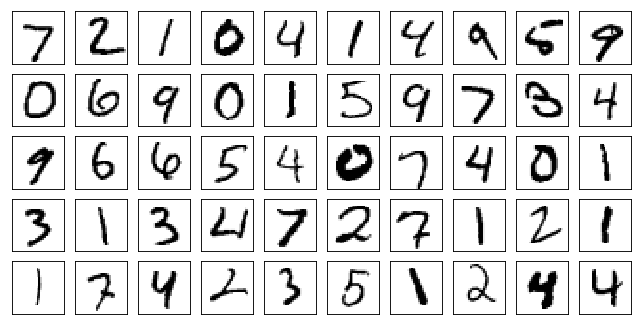

восстановленные данные


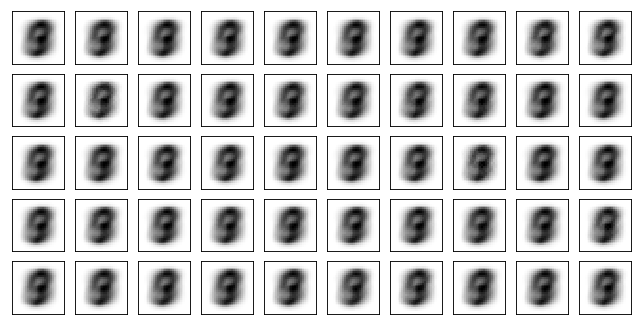

In [36]:
print('исходные данные')
plot_mnist(data.data.numpy(), (5, 10))
print('восстановленные данные')
plot_mnist(to_plot, (5, 10))